In [1]:
# Downloading data
!pip install grad-cam
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=c66d7c80bc2150058664def6f0bc6be3ecf1cd50951e0a5ddadcd50cc63d288f
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=dc6eab2c8fa55ad1e13ca4aa0e6f0cbb7600c334f0786c386dca888d387853d7
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [2]:
import torch
import medmnist
import os
import datetime
import numpy as np
import cv2
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from PIL import Image
from medmnist import INFO
from torchvision import transforms, models
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda:0


# Model and Data Loader

The code is based on the tutorial found: https://colab.research.google.com/drive/1QNit0tU1lW2mlDzx8XJRzSVn5p06Veop?usp=share_link

In [13]:
# defining parameters
model_name = "resnet50" # optional: choose different model for comparison (resnet101)
batch_size = 128
freeze = True
pretrained = True
trainable_layers = 2
data_flag = 'pathmnist' # optional: choose a different dataset for comparison (pathmnist)
info = INFO[data_flag]
num_classes = len(info["label"])
print(num_classes)
DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# prepare dataset
train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
valid_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

image_shape = next(iter(train_loader))[0][0].cpu().numpy().shape
print(f"Image shape: {image_shape}")

# prepare model
if pretrained:
    weights = "DEFAULT"
if not pretrained:
    weights = None

# load model
model = getattr(models, model_name)(weights=weights)
module_names = [name for name, module in model.named_children()]
layer_names = [name for name in module_names if "layer" in name]
print(layer_names)
if freeze:
    trainable_layer_names = list()
    # freeze layers
    for param in model.parameters():
        param.requires_grad = False
    # unfreeze layers
    for param in model.fc.parameters():
        param.requires_grad = True
    for i, layer_name in enumerate(layer_names):
        if i + 1 > len(layer_names) - trainable_layers:
            trainable_layer_names.append(layer_name)
            for param in getattr(model, layer_name).parameters():
                param.requires_grad = True
    # replace fc layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.fc.reset_parameters()

print(f"Trainable layers: {', '.join(trainable_layer_names)}")

9
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Image shape: (3, 28, 28)
['layer1', 'layer2', 'layer3', 'layer4']
Trainable layers: layer3, layer4


# Benchmark Definitions with CAM

In [14]:
def benchmark(data_loader, model, data_index=None, size_threshold=100):
    print(f"Grad-cam testing")

    model = model.to(device)
    input_tensor, targets = next(iter(data_loader))

    if data_index is None:
        data_index = np.random.randint(len(input_tensor)-1)

    input_tensor = input_tensor.to(device)[data_index]
    targets = targets[data_index].cpu().numpy()
    image = np.uint8(255 * input_tensor.cpu().numpy().transpose((1, 2, 0)))

    layer_names = [name for name, module in model.named_children() if "layer" in name]
    target_layers = [getattr(model, layer_names[-2])]

    methods = [ ("GradCAM", GradCAM(model=model, target_layers=target_layers)),
                ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
                ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
                ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
                ("RandomCAM", RandomCAM(model=model, target_layers=target_layers)) ]

    images = [image]
    method_names = list()

    for name, method in methods:
        method_names.append(name)
        with method as cam_method:
            cam = cam_method(input_tensor=input_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(targets)])
            cam_on_image = show_cam_on_image(np.float32(image/255), cam[0, :], use_rgb=True)

        images.append(cam_on_image)

    images = np.hstack(images)

    if len(image) < size_threshold:
        new_shape = (size_threshold * (len(methods) + 1), size_threshold)
        images = cv2.resize(images, new_shape, interpolation=4)

    return Image.fromarray(images), method_names, data_index

# Defining training and testing functions

In [15]:

def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)

    # some custom stuff
    saved_models = dict()
    data_index = None

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []

        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):

            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target)
                valid_losses.append(loss.item())

        images, cam_method_names, data_index = benchmark(train_loader, model, data_index)
        print("Raw, " + ", ".join(cam_method_names))
        display(images)
        saved_models[epoch] = model
        print(\
            f"Train Epoch: {epoch + 1:02d} | " +
            f"Loss: {np.mean(losses):.6f} | " +
            f"Validation loss: {np.mean(valid_losses):.6f} | " +
            f"Acc: {np.mean(accuracies) * 100:.6f}"
        )
    return model

In [16]:
def test(device, model, data_loader, mean=0.5432, std=0.2731):
    data_index = None

    model.eval()
    pred_list = []
    pred_labels = []
    correct = 0

    with torch.no_grad():
        for index, (images, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            images = images.to(device)
            target = target

            output = model(images).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_labels.append(labels)
            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    images, cam_method_names, data_index = benchmark(test_loader, model, data_index)
    print("Raw, " + ", ".join(cam_method_names))
    display(images)

    return np.concatenate(pred_list), np.concatenate(pred_labels)

In [17]:
def save_model(model, name=''):
    path = os.path.dirname(os.path.abspath(os.getcwd()))
    time = datetime.datetime.now().strftime('%d-%m-%Y-%H:%M:%S')
    path = os.path.join(path, 'Sheet_4', 'models', name + time + '.pth')

    torch.save(model, path)
    print('Model saved.')

def load_model(name=''):
    path = os.path.dirname(os.path.abspath(os.getcwd()))
    path = os.path.join(path,  'Sheet_4', 'models', name + '.pth')

    model = torch.load(path)

    print('Model loaded.')
    return model

# Evaluating the CAM methods, running the model

Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 24.67it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 91.30it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


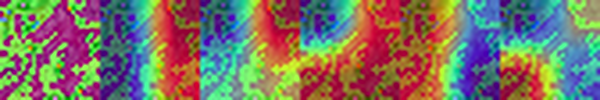

Train Epoch: 01 | Loss: 1.648030 | Validation loss: 1.087195 | Acc: 46.066377


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 22.57it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 91.29it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


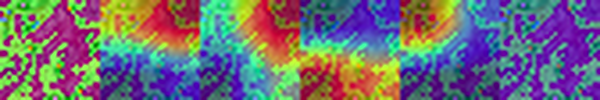

Train Epoch: 02 | Loss: 0.473432 | Validation loss: 0.338584 | Acc: 83.825314


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 22.00it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 90.21it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


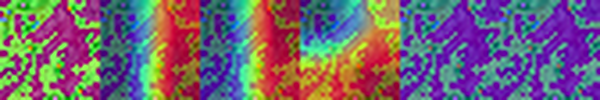

Train Epoch: 03 | Loss: 0.275362 | Validation loss: 0.289122 | Acc: 90.501820


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 19.04it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 85.49it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


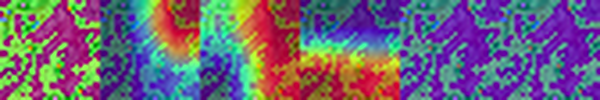

Train Epoch: 04 | Loss: 0.188287 | Validation loss: 0.275804 | Acc: 93.642356


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.66it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 83.24it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


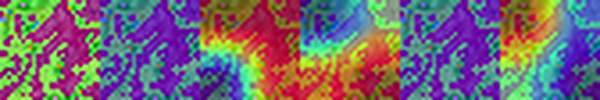

Train Epoch: 05 | Loss: 0.125176 | Validation loss: 0.280086 | Acc: 96.060458


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 18.73it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 56.21it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


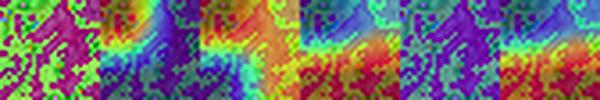

Train Epoch: 06 | Loss: 0.077866 | Validation loss: 0.298607 | Acc: 97.826039


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 20.20it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 64.57it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


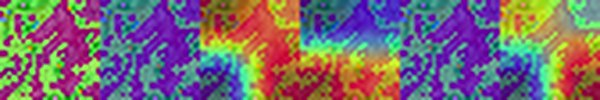

Train Epoch: 07 | Loss: 0.044526 | Validation loss: 0.333577 | Acc: 98.935769


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.71it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 64.99it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


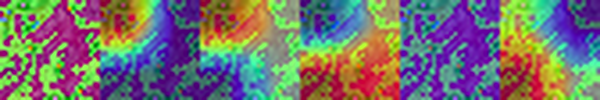

Train Epoch: 08 | Loss: 0.023069 | Validation loss: 0.380047 | Acc: 99.579412


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.49it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 87.27it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


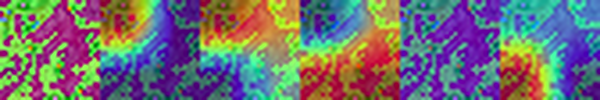

Train Epoch: 09 | Loss: 0.010898 | Validation loss: 0.430700 | Acc: 99.841309


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 84.45it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


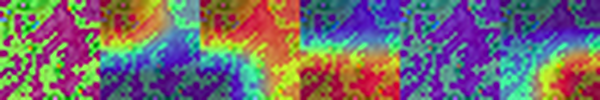

Train Epoch: 10 | Loss: 0.007655 | Validation loss: 0.478459 | Acc: 99.892356


In [18]:
# Define training parameters
epochs = 10
learning_rate = 1e-5

# train the model
model_trained = train(device, model, train_loader, epochs, learning_rate)

Test-loop: 100%|██████████| 57/57 [00:02<00:00, 19.27it/s]


Test Accuracy: 87.033426
Grad-cam testing


100%|██████████| 32/32 [00:00<00:00, 90.00it/s]

Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


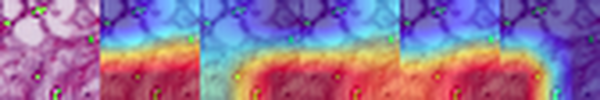

In [19]:
# test the model
predictions, labels = test(device, model, test_loader)